# How to Develop a 1D GAN from Scratch

In this notebook I will be making notes and commenting on the code from https://datahacker.rs/006-gans-how-to-develop-a-1d-gan-from-scratch/ which gives a step by step guide on how GANs can be implemented using PyTorch. The example we will be using is a sine wave.

## What is a GAN?

A GAN consists of having two deep neural networks called the Generator and the Discriminator. The Gan also uses real data samples and the goal of the Generator is to try and replicate samples from the real dataset to create new unseen images. These images are then fed into the Discriminator. Both the Generator and the Discrimator will work together to optimise one another.

First we need to import the relevant libraries which are PyTorch and matplotlib

In [13]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

Next we have to define a 1D function that we want ot model with the GANs. The input will be x data variables and the true data will be created from the sine function. If the outputted y plot is the same as the sine function then it wil be regarded as a true data label, if not then it will be judged as a fake data point. The job of the Generator is try to learn what causes a y variable to be true or not.

Below we will create a sine function which takes an x input and will output the corresponding floating point y for that input. This can be tested with some example inputs.

In [14]:
def sine_function(x):
    return torch.sin(x)

# test sine_function()    
print(sine_function(torch.tensor(torch.pi * 0.5 )))
print(sine_function(torch.tensor(torch.pi * 0. )))

tensor(1.)
tensor(0.)


Next we will create the random x variables that will be used and find the corresponding y points for these x inputs. We can then plot this to show our sine wave

Text(0.5, 1.0, 'Plot of our sine wave')

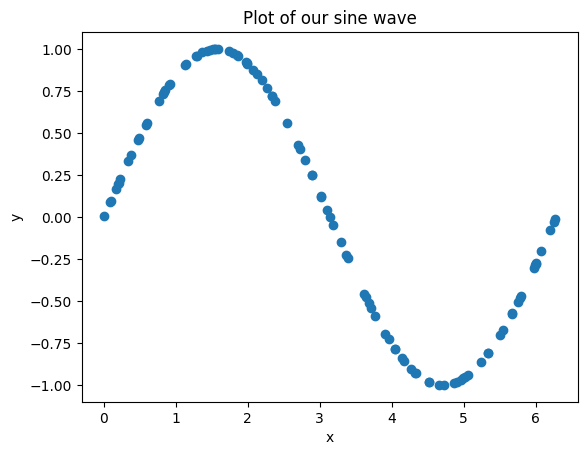

In [15]:
x = torch.rand(100) * 2 * torch.pi
y = sine_function(x)
# plot the sine wave function
plt.scatter(x.numpy(), y.numpy())

plt.xlabel("x")
plt.ylabel("y")
plt.title('Plot of our sine wave')

Now we can create the function that will be used to generate data samples. When creating a proper model these will come from a dataset for example a set of images. This function should not only return the variable but also return the label. As all of these are real labels they should all be returned with the label 1.

In [16]:
def generate_data_samples(n=100):
    # here we define the number of n numbers from a Uniform distribution
    x1 = torch.rand(n) * 2 * torch.pi
    x2 = sine_function(x1)
    x1 = x1.view(n,1)
    x2 = x2.view(n,1)
    y_data = torch.ones((n,1))

    return torch.hstack((x1, x2)), y_data

Now we can create the test data using the above function. We will create 100 test datapoints.

Text(0.5, 1.0, 'Plot of our test data sine wave')

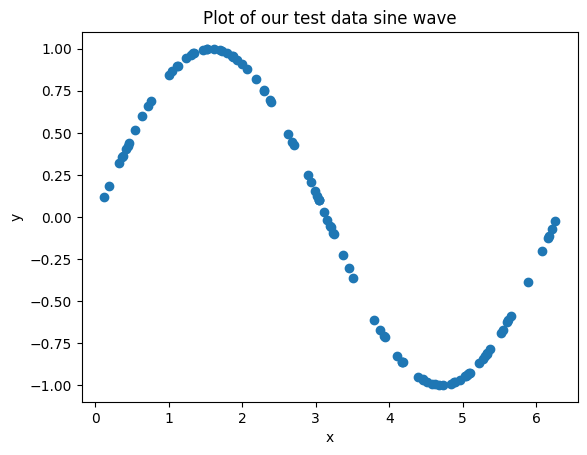

In [19]:
test_generated_data = generate_data_samples(100)

plt.scatter(test_generated_data[0][:,0].numpy(), test_generated_data[0][:,1].numpy())
plt.xlabel("x")
plt.ylabel("y")
plt.title('Plot of our test data sine wave')

To develop the Generator we will develop a simple model. We ill assume that is is a neural network which has fully connected layers. We will use an input that is a vector that is equal to 5. This menas that we want to develop a generator whose input is a random vector of 5 elements. Al the output we ewant to get two elements, where the second one models the function

The discrimator will also be a neural netowrk. The input vector will be of size 2. The input vectors will come from the read data or the fake generated dataset which uses the generator model. The discrimator should distinguish between the real data (1) and the fake data(0).

To define the discriminator model we will create a simple neural network. An input to this network will be a 2 dimensional vector that has the x and sine(x) of that x.

The goal of the discriminator is to distinguish between the real and fake data samples. Now we will also create a function that will create 'dummy' fake data. This function will create a pair of x and y numbers that are completely random. The discriminator network will have a simple output as it will be a simple binary classification problem

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #hidden layer has 25 neurons
        self.fc1 = nn.Linear(2, 25)
        #output layer only has 1 neuron as it is either 1 or 0
        self.fc2 = nn.Linear(25,1)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

We can do a sanity check at this stage to check that the discrimator is working. We can pass in a random 2 element vector.

In [21]:
discriminator = Discriminator()
# test a discriminator with a simple input - sanity check
x_data_test = torch.rand(2)
discriminator(x_data_test)

NameError: name 'F' is not defined